<a href="https://colab.research.google.com/github/vishxm/DL-NBs/blob/main/MNIST_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with CNNs

## Importing libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## Creating the model for our neural network

In [4]:
class mnistModel(nn.Module): #inheriting from nn.Module class
    def __init__(self):
        super(mnistModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2) ## in 1, out 32, with kernel size 5 and padding 2
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) ## in 32, out 64, with kernel size 5 and padding 2
        self.fc1 = nn.Linear(64*7*7, 1024) ## feature map size is 7*7 by pooling
        self.fc2 = nn.Linear(1024, 10) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) #reshape
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x)
            
        return x

model = mnistModel()
model.cuda()

mnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

## Defining train and test data loader

In [5]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000
)

In [7]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([1024, 3136])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training the model with 15 epochs

In [9]:
model.train()
train_loss = []
train_accu = []
i = 0

for epoch in range(15):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_loss.append(loss.data)
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = torch.true_divide(prediction.eq(target.data).sum() * 100,
                            batch_size)
        train_accu.append(accuracy)

        if i%1000 == 0:
            print("Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}".format(i, loss.data, accuracy))

        i += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Train Step: 0	Loss: 2.305	Accuracy: 10.000
Train Step: 1000	Loss: 0.059	Accuracy: 100.000
Train Step: 2000	Loss: 0.105	Accuracy: 96.000
Train Step: 3000	Loss: 0.018	Accuracy: 100.000
Train Step: 4000	Loss: 0.005	Accuracy: 100.000
Train Step: 5000	Loss: 0.121	Accuracy: 94.000
Train Step: 6000	Loss: 0.012	Accuracy: 100.000
Train Step: 7000	Loss: 0.106	Accuracy: 96.000
Train Step: 8000	Loss: 0.040	Accuracy: 98.000
Train Step: 9000	Loss: 0.004	Accuracy: 100.000
Train Step: 10000	Loss: 0.005	Accuracy: 100.000
Train Step: 11000	Loss: 0.002	Accuracy: 100.000
Train Step: 12000	Loss: 0.010	Accuracy: 100.000
Train Step: 13000	Loss: 0.029	Accuracy: 98.000
Train Step: 14000	Loss: 0.001	Accuracy: 100.000
Train Step: 15000	Loss: 0.041	Accuracy: 98.000
Train Step: 16000	Loss: 0.002	Accuracy: 100.000
Train Step: 17000	Loss: 0.002	Accuracy: 100.000


In [10]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.get_device_name() #checking the GPU provided by Google Colab

'Tesla P100-PCIE-16GB'

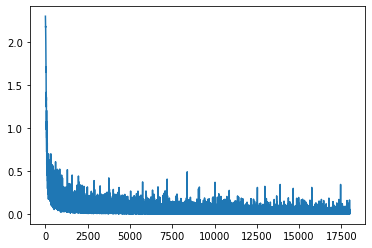

In [12]:
plt.plot(np.arange(len(train_loss)), train_loss)

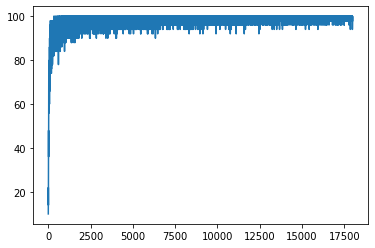

In [13]:
plt.plot(np.arange(len(train_accu)), train_accu)

## Evaulating the trained model

In [14]:
model.eval()
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda()
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print("\n\nTest set Accuracy : {:.2f}%".format(100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()




Test set Accuracy : 99.27%
